# بسم الله الرحمن الرحيم

# Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from datetime import date

from scipy.stats import norm
from math import atanh
import string
from pandas.core.array_algos import replace
from scipy import stats
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout ,BatchNormalization ,Activation
from tensorflow.keras.callbacks import  ReduceLROnPlateau
import keras
nltk.download('stopwords')

from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
##replace It before Submit
#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [2]:
def States_Encoding(df,path):
  states=joblib.load(path)
  lon=list()
  lat=list()
  for i in df['State']:
    lon.append(states[i]['usa_state_longitude'])
    lat.append(states[i]['usa_state_latitude'])
  df['long']=lon
  df['lat']=lat
  df.drop(['State',"City"],axis=1,inplace=True)
  del lon
  del lat
  return df    

In [3]:
def Cols_To_DT(df,printout):
  cols=list(filter(lambda x:x.endswith("Date"),df.columns))
  for col in cols:
    df[col]= pd.to_datetime(df[col])
  if(printout==True):
    print(df.select_dtypes(include="datetime").columns,"Are Date Time")
  return df    


In [4]:
def dict_to_cols(df):
  MainCat=list()
  SubCat=list()
  for i in df['CategoryTree']:
    d=eval(i)
    MainCat.append(d['MainCategory'])
    SubCat.append(d['SubCategory'])
  df['MainCat']=MainCat
  df['SubCat']=SubCat
  df.drop("CategoryTree",axis=1,inplace=True)  
  return df

In [5]:
def preprocessed(df,object_cv,Scaler,cols,retY=False):
    
    df['Profit']=df['ReturnCategory']
    df.drop('ReturnCategory',axis=1,inplace=True)
    df['Profit']=df['Profit'].replace({'High Loss'  : 0 , 'Low Loss' : 1 , 'Low Profit' :2 , 'Medium Profit' : 3 , 'High Profit' : 4 })
    #Date Time Prob
    df=Cols_To_DT(df,False)
    #Category Tree
    df=dict_to_cols(df)
    df['delivery days']=df['Ship Date']-df['Order Date']
    df['delivery days']=df['delivery days'].dt.days
    
    df.drop(["Ship Date","Row ID","Country"],axis=1,inplace=True)
    
    df['Quantity']=np.log2(df['Quantity']+1)
    df['Discount']=np.log2(df['Discount']+1)
    df['Sales']=np.log10(df['Sales'])

    df['Product ID']=df['Product ID'].str.split('-',expand=True)[2].astype('int64')
    df['Customer ID']=df['Customer ID'].str.split('-',expand=True)[1].astype('int64')
    df['year']=df['Order ID'].str.split('-',expand=True)[1].astype('int64')
    df['month']=df['Order Date'].dt.month.astype('int64')
    df['Order IDs']=df['Order ID'].str.split('-',expand=True)[2].astype('int64')    
    df['Order IDs']=df['Order IDs'].astype('int64')
    df.drop(['Order ID',"Order Date"],axis=1,inplace=True)
    if(retY==True):
      X=df.drop('Profit',axis=1)
      Y=df.loc[:,'Profit']
    else:
      X=df  
    
    ###Remeber To write Scaler###
    scaled_cols=X.select_dtypes(exclude=["object"]).columns
    X[scaled_cols]=Scaler.transform(X[scaled_cols])

    X=States_Encoding(X,r"Saved Object\UStatesDict.pkl")
    num_feature=[0]
    
    for ghandy,i in enumerate(X.select_dtypes(include='object').columns):

        sentences = X[i].values
        cleaned_sentence = []
        for sentence in sentences:
            word = sentence.lower()  
            word = re.sub(r'^RT[\s]+', '', word)
            word = re.sub(r'#',"",word)
            word = word.split()
            word = [i for i in word if i not in set(stopwords.words('english'))]          
            word = " ".join(word)               ##joining our words back to sentences
            cleaned_sentence.append(word)       ##appending our preprocessed sentence into a new list
          

        BagofwordSs = object_cv[ghandy].transform(cleaned_sentence).toarray()
        num_feature.append(num_feature[-1]+BagofwordSs.shape[1])  
        if (ghandy==0):
          CumBagofwords = BagofwordSs
        else:
          CumBagofwords = np.concatenate([CumBagofwords,BagofwordSs],axis=1)

    X.drop(X.select_dtypes(include='object').columns,axis=1,inplace=True)
    result = pd.concat([X.reset_index(), pd.DataFrame(CumBagofwords)], axis=1)
    X=pd.DataFrame(result)   
    X.columns=X.columns.astype(str)
    #print(X.columns)
    new_X=X.loc[:,cols]
    if(retY==True):
        return new_X,Y
    else:
        return new_X
    

# Fetch Data

In [115]:
df=pd.read_csv(r"megastore-classification-dataset.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,ReturnCategory
0,7492,US-2017-118598,11/16/2017,11/16/2017,Same Day,CM-12190,Charlotte Melton,Consumer,United States,Utica,New York,13501,East,TEC-PH-10002583,"{'MainCategory': 'Technology', 'SubCategory': ...",iOttie HLCRIO102 Car Mount,119.940,6,0.0,Low Profit
1,6641,CA-2017-128328,8/5/2017,8/9/2017,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,Indianapolis,Indiana,46203,Central,OFF-BI-10001989,"{'MainCategory': 'Office Supplies', 'SubCatego...",Premium Transparent Presentation Covers by GBC,125.880,6,0.0,Medium Profit
2,9243,CA-2014-113271,7/9/2014,7/14/2014,Standard Class,DS-13030,Darrin Sayre,Home Office,United States,San Francisco,California,94122,West,OFF-BI-10002609,"{'MainCategory': 'Office Supplies', 'SubCatego...",Avery Hidden Tab Dividers for Binding Systems,14.304,6,0.2,Low Profit
3,2469,CA-2017-128755,5/4/2017,5/8/2017,Standard Class,MK-18160,Mike Kennedy,Consumer,United States,Newport News,Virginia,23602,South,OFF-PA-10004983,"{'MainCategory': 'Office Supplies', 'SubCatego...",Xerox 23,32.400,5,0.0,Medium Profit
4,3136,CA-2017-164168,11/12/2017,11/18/2017,Standard Class,LS-16975,Lindsay Shagiari,Home Office,United States,Dallas,Texas,75081,Central,OFF-ST-10002583,"{'MainCategory': 'Office Supplies', 'SubCatego...",Fellowes Neat Ideas Storage Cubes,77.952,3,0.2,Low Loss


In [116]:
nullreplacer=dict()
for col in df.columns:
    if df[col].dtype != 'object':
        nullreplacer[col]=df[col].mean()
    else:    
        nullreplacer[col]=df[col].mode()[0]

In [117]:
nullreplacer

{'Row ID': 5010.902564102564,
 'Order ID': 'CA-2017-100111',
 'Order Date': '11/10/2016',
 'Ship Date': '9/26/2017',
 'Ship Mode': 'Standard Class',
 'Customer ID': 'PP-18955',
 'Customer Name': 'Paul Prost',
 'Segment': 'Consumer',
 'Country': 'United States',
 'City': 'New York City',
 'State': 'California',
 'Postal Code': 55339.397123202005,
 'Region': 'West',
 'Product ID': 'OFF-PA-10001970',
 'CategoryTree': "{'MainCategory': 'Office Supplies', 'SubCategory': 'Binders'}",
 'Product Name': 'Staples',
 'Sales': 228.21197003126545,
 'Quantity': 3.7642276422764227,
 'Discount': 0.15588492808005827,
 'ReturnCategory': 'Medium Profit'}

In [7]:
from sklearn.model_selection import train_test_split
df,df_test=train_test_split(df,train_size=0.8,shuffle=True,random_state=2002)

In [8]:
df.shape,df_test.shape

((6396, 20), (1599, 20))

In [9]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'CategoryTree', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'ReturnCategory'],
      dtype='object')

In [10]:
df['ReturnCategory'].value_counts()
dic_val={'High Loss'  : 0 , 'Low Loss' : 1 , 'Low Profit' :2 , 'Medium Profit' : 3 , 'High Profit' : 4 }
def get_code(e):
    for x, y in dic_val.items():
        if e == y:
            return x 

In [11]:
L=[]
for i in df['ReturnCategory']:
    L.append(dic_val[i])
df['Profit']=L 

In [12]:
df.drop('ReturnCategory',inplace=True,axis=1)
print(df.isnull().sum(axis=0))

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
CategoryTree     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


## Train Test Split

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         6396 non-null   int64  
 1   Order ID       6396 non-null   object 
 2   Order Date     6396 non-null   object 
 3   Ship Date      6396 non-null   object 
 4   Ship Mode      6396 non-null   object 
 5   Customer ID    6396 non-null   object 
 6   Customer Name  6396 non-null   object 
 7   Segment        6396 non-null   object 
 8   Country        6396 non-null   object 
 9   City           6396 non-null   object 
 10  State          6396 non-null   object 
 11  Postal Code    6396 non-null   int64  
 12  Region         6396 non-null   object 
 13  Product ID     6396 non-null   object 
 14  CategoryTree   6396 non-null   object 
 15  Product Name   6396 non-null   object 
 16  Sales          6396 non-null   float64
 17  Quantity       6396 non-null   int64  
 18  Disco

In [14]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,Profit
6800,6060,CA-2014-138072,12/30/2014,1/3/2015,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Philadelphia,Pennsylvania,19120,East,TEC-AC-10004859,"{'MainCategory': 'Technology', 'SubCategory': ...","Maxell Pro 80 Minute CD-R, 10/Pack",27.968,2,0.2,2
6590,2656,CA-2017-112515,9/17/2017,9/21/2017,Second Class,AS-10225,Alan Schoenberger,Corporate,United States,Provo,Utah,84604,West,OFF-BI-10004233,"{'MainCategory': 'Office Supplies', 'SubCatego...","GBC Pre-Punched Binding Paper, Plastic, White,...",25.584,2,0.2,2
1277,8454,CA-2016-125087,4/18/2016,4/23/2016,Standard Class,TH-21115,Thea Hudgings,Corporate,United States,Houston,Texas,77070,Central,OFF-ST-10001780,"{'MainCategory': 'Office Supplies', 'SubCatego...",Tennsco 16-Compartment Lockers with Coat Rack,1554.936,3,0.2,3
2012,7986,CA-2016-151498,4/21/2016,4/24/2016,First Class,DN-13690,Duane Noonan,Consumer,United States,Seattle,Washington,98115,West,OFF-BI-10004967,"{'MainCategory': 'Office Supplies', 'SubCatego...",Round Ring Binders,8.320,5,0.2,2
2234,7687,CA-2016-169838,11/25/2016,11/29/2016,Standard Class,BB-11545,Brenda Bowman,Corporate,United States,Jackson,Michigan,49201,Central,FUR-TA-10001095,"{'MainCategory': 'Furniture', 'SubCategory': '...",Chromcraft Round Conference Tables,1568.610,9,0.0,4


In [15]:
df['Order Date']=pd.to_datetime(df['Order Date'])

In [16]:
opsd_daily = df.set_index('Order Date')


In [17]:
opsd_daily=opsd_daily.sort_index()

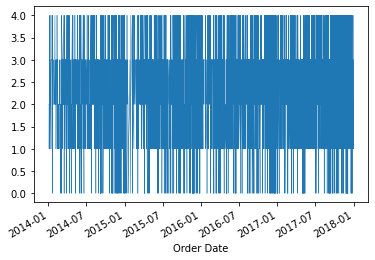

In [18]:
opsd_daily['Profit'].plot(linewidth=0.5);


In [19]:
opsd_daily['Product Name'].value_counts()

Staples                                                                                            28
Staple envelope                                                                                    27
Easy-staple paper                                                                                  25
Avery Non-Stick Binders                                                                            14
KI Adjustable-Height Table                                                                         14
                                                                                                   ..
Computer Printout Paper with Letter-Trim Fine Perforations                                          1
Rediform S.O.S. Phone Message Books                                                                 1
Letter Slitter                                                                                      1
Cubify CubeX 3D Printer Triple Head Print                                         

<AxesSubplot:xlabel='Order Date'>

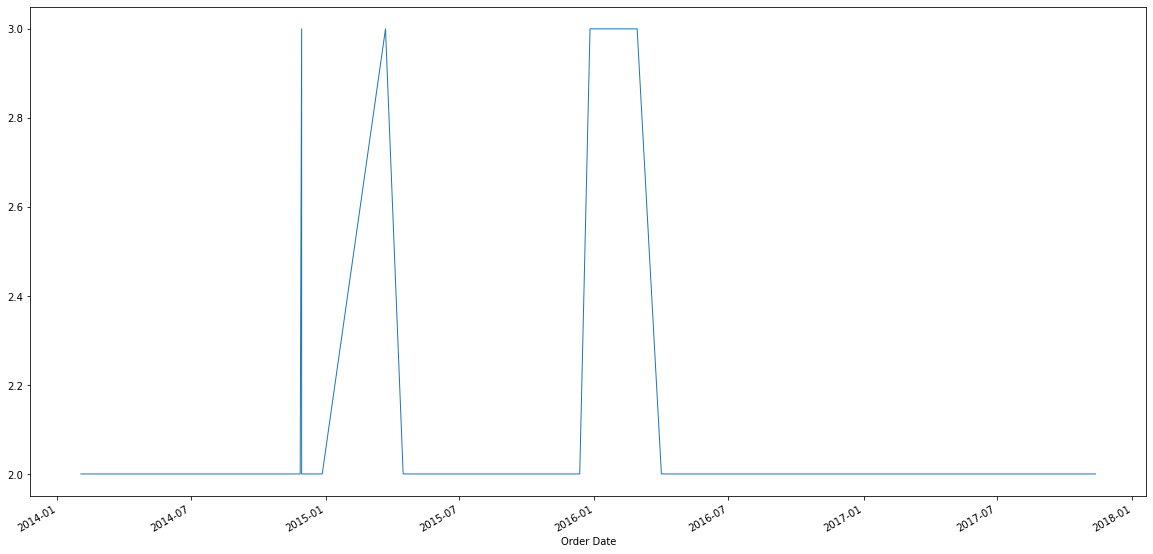

In [20]:
plt.figure(figsize=(20,10))
opsd_daily[opsd_daily['Product Name']=='Staples']['Profit'].plot(linewidth=1)

In [21]:
opsd_daily

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,CategoryTree,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,
2014-01-03,7981,CA-2014-103800,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,"{'MainCategory': 'Office Supplies', 'SubCatego...","Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,2
2014-01-04,740,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,"{'MainCategory': 'Office Supplies', 'SubCatego...",Avery 508,11.784,3,0.2,2
2014-01-04,742,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,"{'MainCategory': 'Office Supplies', 'SubCatego...",GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,1
2014-01-06,7478,CA-2014-167199,1/10/2014,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,Kentucky,42420,South,TEC-PH-10004977,"{'MainCategory': 'Technology', 'SubCategory': ...",GE 30524EE4,391.980,2,0.0,4
2014-01-06,7480,CA-2014-167199,1/10/2014,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,Kentucky,42420,South,OFF-FA-10001883,"{'MainCategory': 'Office Supplies', 'SubCatego...","Alliance Super-Size Bands, Assorted Sizes",31.120,4,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30,909,CA-2017-143259,1/3/2018,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,New York,10009,East,OFF-BI-10003684,"{'MainCategory': 'Office Supplies', 'SubCatego...",Wilson Jones Legal Size Ring Binders,52.776,3,0.2,3
2017-12-30,907,CA-2017-143259,1/3/2018,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,New York,10009,East,FUR-BO-10003441,"{'MainCategory': 'Furniture', 'SubCategory': '...","Bush Westfield Collection Bookcases, Fully Ass...",323.136,4,0.2,3
2017-12-30,908,CA-2017-143259,1/3/2018,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,New York,10009,East,TEC-PH-10004774,"{'MainCategory': 'Technology', 'SubCategory': ...",Gear Head AU3700S Headset,90.930,7,0.0,2


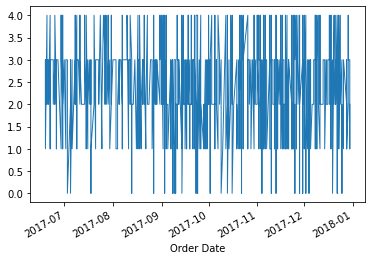

In [22]:
opsd_daily['Profit'][5000:].plot(linewidth=1);


In [23]:
opsd_daily['Profit']

Order Date
2014-01-03    2
2014-01-04    2
2014-01-04    1
2014-01-06    4
2014-01-06    2
             ..
2017-12-30    3
2017-12-30    3
2017-12-30    2
2017-12-30    1
2017-12-30    2
Name: Profit, Length: 6396, dtype: int64

In [24]:
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.arima_model import ARMA  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

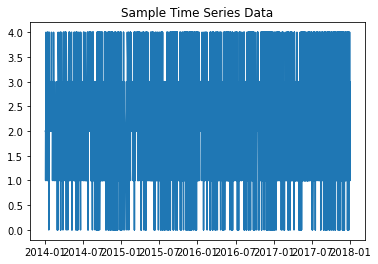

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 Profit   No. Observations:                 6396
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8716.666
Date:                Tue, 23 May 2023   AIC                          17439.331
Time:                        14:51:21   BIC                          17459.621
Sample:                             0   HQIC                         17446.354
                               - 6396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0748      0.012      6.094      0.000       0.051       0.099
ma.L1         -0.9999      0.002   -582.293      0.000      -1.003      -0.997
sigma2         0.8931      0.018     50.827      0.0

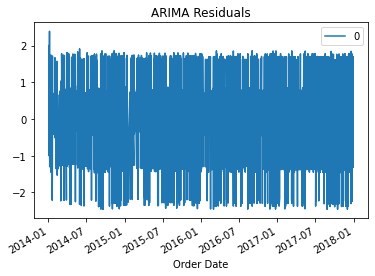

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

plt.plot(opsd_daily['Profit'])
plt.title('Sample Time Series Data')
plt.show()

# fit an ARIMA model to the data
model = ARIMA(opsd_daily['Profit'], order=(1, 1, 1))
results = model.fit()

# print the summary of the model
print(results.summary())

# plot the residuals of the model
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.title('ARIMA Residuals')
plt.show()

In [26]:
model = ARMA(opsd_daily['Profit'], order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict( start= 0, end = (6000) )

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [27]:
print('Predicted value for Moving Average 2,1 ',yhat)


Predicted value for Moving Average 2,1  Order Date
2014-01-03    2.330343
2014-01-04    2.305680
2014-01-04    2.300502
2014-01-06    2.223163
2014-01-06    2.423210
                ...   
2017-11-20    2.316729
2017-11-20    2.309797
2017-11-20    2.376778
2017-11-20    2.242115
2017-11-20    2.220168
Length: 6001, dtype: float64


### Here we Read The data and we found


1.   We have No Nulls
2.   Category Tree column is not written well
3.   We have to deal with (Order Date and Ship Date)






## Converting Datatypes

In [28]:
#Date DataType Preparation
df=Cols_To_DT(df,True)
#Fixing Dictionary Problem of CategoryTree
df=dict_to_cols(df)

Index(['Order Date', 'Ship Date'], dtype='object') Are Date Time


In [29]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat
6800,6060,CA-2014-138072,2014-12-30,2015-01-03,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Philadelphia,...,19120,East,TEC-AC-10004859,"Maxell Pro 80 Minute CD-R, 10/Pack",27.968,2,0.2,2,Technology,Accessories
6590,2656,CA-2017-112515,2017-09-17,2017-09-21,Second Class,AS-10225,Alan Schoenberger,Corporate,United States,Provo,...,84604,West,OFF-BI-10004233,"GBC Pre-Punched Binding Paper, Plastic, White,...",25.584,2,0.2,2,Office Supplies,Binders
1277,8454,CA-2016-125087,2016-04-18,2016-04-23,Standard Class,TH-21115,Thea Hudgings,Corporate,United States,Houston,...,77070,Central,OFF-ST-10001780,Tennsco 16-Compartment Lockers with Coat Rack,1554.936,3,0.2,3,Office Supplies,Storage
2012,7986,CA-2016-151498,2016-04-21,2016-04-24,First Class,DN-13690,Duane Noonan,Consumer,United States,Seattle,...,98115,West,OFF-BI-10004967,Round Ring Binders,8.320,5,0.2,2,Office Supplies,Binders
2234,7687,CA-2016-169838,2016-11-25,2016-11-29,Standard Class,BB-11545,Brenda Bowman,Corporate,United States,Jackson,...,49201,Central,FUR-TA-10001095,Chromcraft Round Conference Tables,1568.610,9,0.0,4,Furniture,Tables


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         6396 non-null   int64         
 1   Order ID       6396 non-null   object        
 2   Order Date     6396 non-null   datetime64[ns]
 3   Ship Date      6396 non-null   datetime64[ns]
 4   Ship Mode      6396 non-null   object        
 5   Customer ID    6396 non-null   object        
 6   Customer Name  6396 non-null   object        
 7   Segment        6396 non-null   object        
 8   Country        6396 non-null   object        
 9   City           6396 non-null   object        
 10  State          6396 non-null   object        
 11  Postal Code    6396 non-null   int64         
 12  Region         6396 non-null   object        
 13  Product ID     6396 non-null   object        
 14  Product Name   6396 non-null   object        
 15  Sales          639

In [31]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000
mean,4996.729831,55188.242183,229.328373,3.780175,0.156865,2.330363
std,2884.333195,31929.953761,591.893515,2.217668,0.206598,0.947648
min,2.000000,1453.000000,0.444000,1.000000,0.000000,0.000000
25%,2507.500000,23456.500000,16.735000,2.000000,0.000000,2.000000
50%,4994.500000,55901.000000,53.770000,3.000000,0.200000,2.000000
75%,7500.250000,90004.000000,208.745000,5.000000,0.200000,3.000000
max,9994.000000,99301.000000,13999.960000,14.000000,0.800000,4.000000


In [32]:
df['delivery days']=df['Ship Date']-df['Order Date']
df['delivery days']=df['delivery days'].dt.days
df['delivery days']=df['delivery days'].astype('float64')
df['year']=df['Order ID'].str.split('-',expand=True)[1].astype('int64') 
df['month']=df['Order Date'].dt.month.astype('int64')
df.drop(["Ship Date"],axis=1,inplace=True)

## Here We have dealt with Datatypes and extracted some other features


1.   We expanded the dictionary in category tree into 2 columns by using (dict_to_cols)
2.   We Turned any feature that ends with "Date" to Datetime datatype 
3.   We created Delivery Days feature




# Analysis

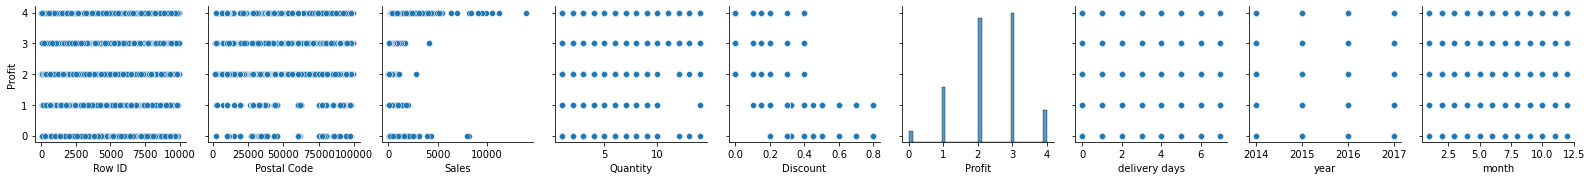

In [33]:
sns.pairplot(df,kind='scatter',y_vars='Profit')

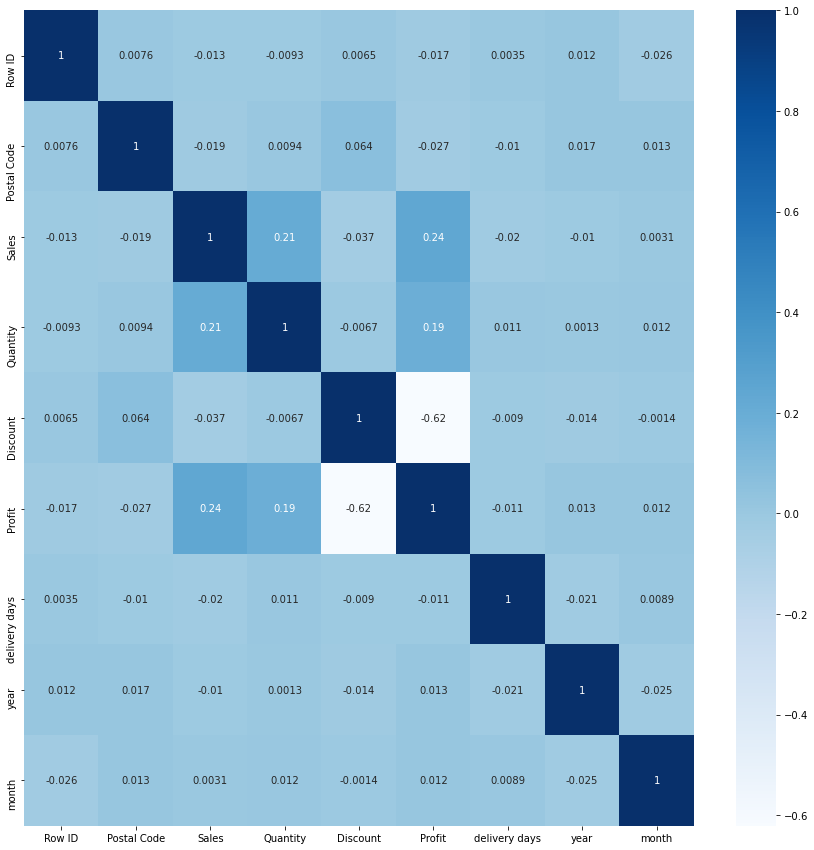

In [34]:
plt.figure(figsize=(15,15))
sns.heatmap(data=df.corr(),cmap='Blues',annot=True)
plt.show()

In [35]:
for col in df.columns:
  if df[col].nunique()==1:
    print(col+" column has one unique value")

Country column has one unique value


 

*   Here we will drop Row ID column because it is too low
*   We will drop Country columns because it has ine unique value

In [36]:
df.drop("Row ID",axis=1,inplace=True)
df.drop("Country",axis=1,inplace=True)

In [37]:
import plotly.graph_objects as go
import plotly.express as px
Taa=df
cols=df.select_dtypes(exclude =['object','datetime']).columns
fig = go.Figure(data=
    go.Parcoords(line = dict(color = Taa['Profit'], colorscale =px.colors.sequential.Blues),
        dimensions = [dict(label=col, values=Taa[col]) for col in cols]))

fig.update_layout(title="Profit")
fig.update_layout(autosize=False,width=2100,height=800)
fig.show()

From the Above Graph We noticed that

*   Products with Zero Discount Gives high profit because it is high quality products the have high rate of selling and they do not lose from its original price
*   Some products with low sales get sold with large quantities because the may beg cheap



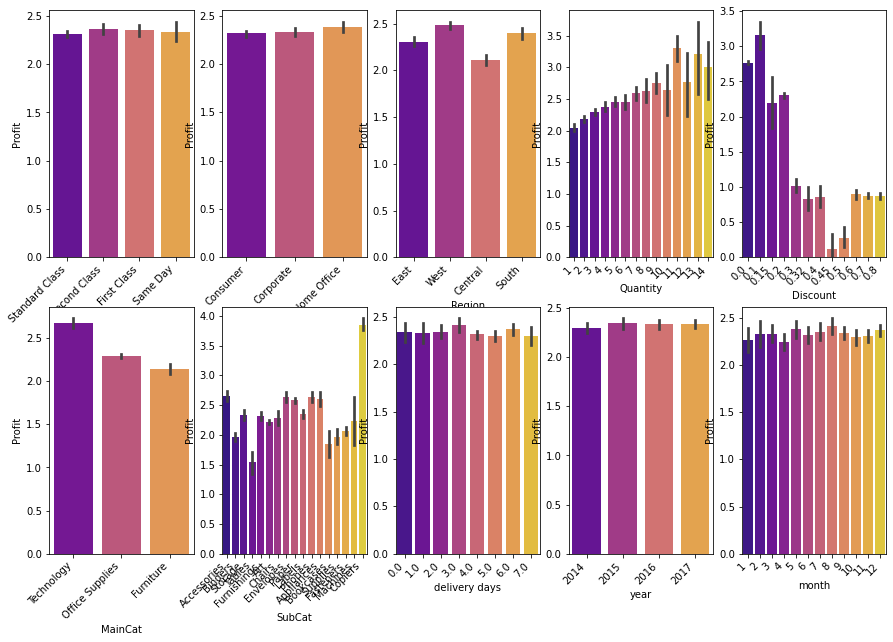

In [38]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1
fig, ax = plt.subplots(2,w,figsize=(15,10))
z=1
for i in df[df.columns[df.nunique()<20]]:
    if(i=='Profit'):
        continue
    plt.subplot(2,w,z)
    df[['Profit',i]].groupby([i],as_index=False).mean().sort_values(by='Profit',ascending=False)
    sns.barplot(x =i, y ='Profit', data = df,palette ='plasma')
    plt.xticks(rotation=45, ha='right')
    z=z+1

From The Above Graph we Noticed


1.   The Mean profit goes high along the years
2.   Technology are the highest profitable products
3.   Copiers Have the highest profit in SubCat which makes sense why Technology Profit is Significally High
4.   January does not have much profit according to no of products sold due to hogh competition between lots of products that causes high profit in some and low in others




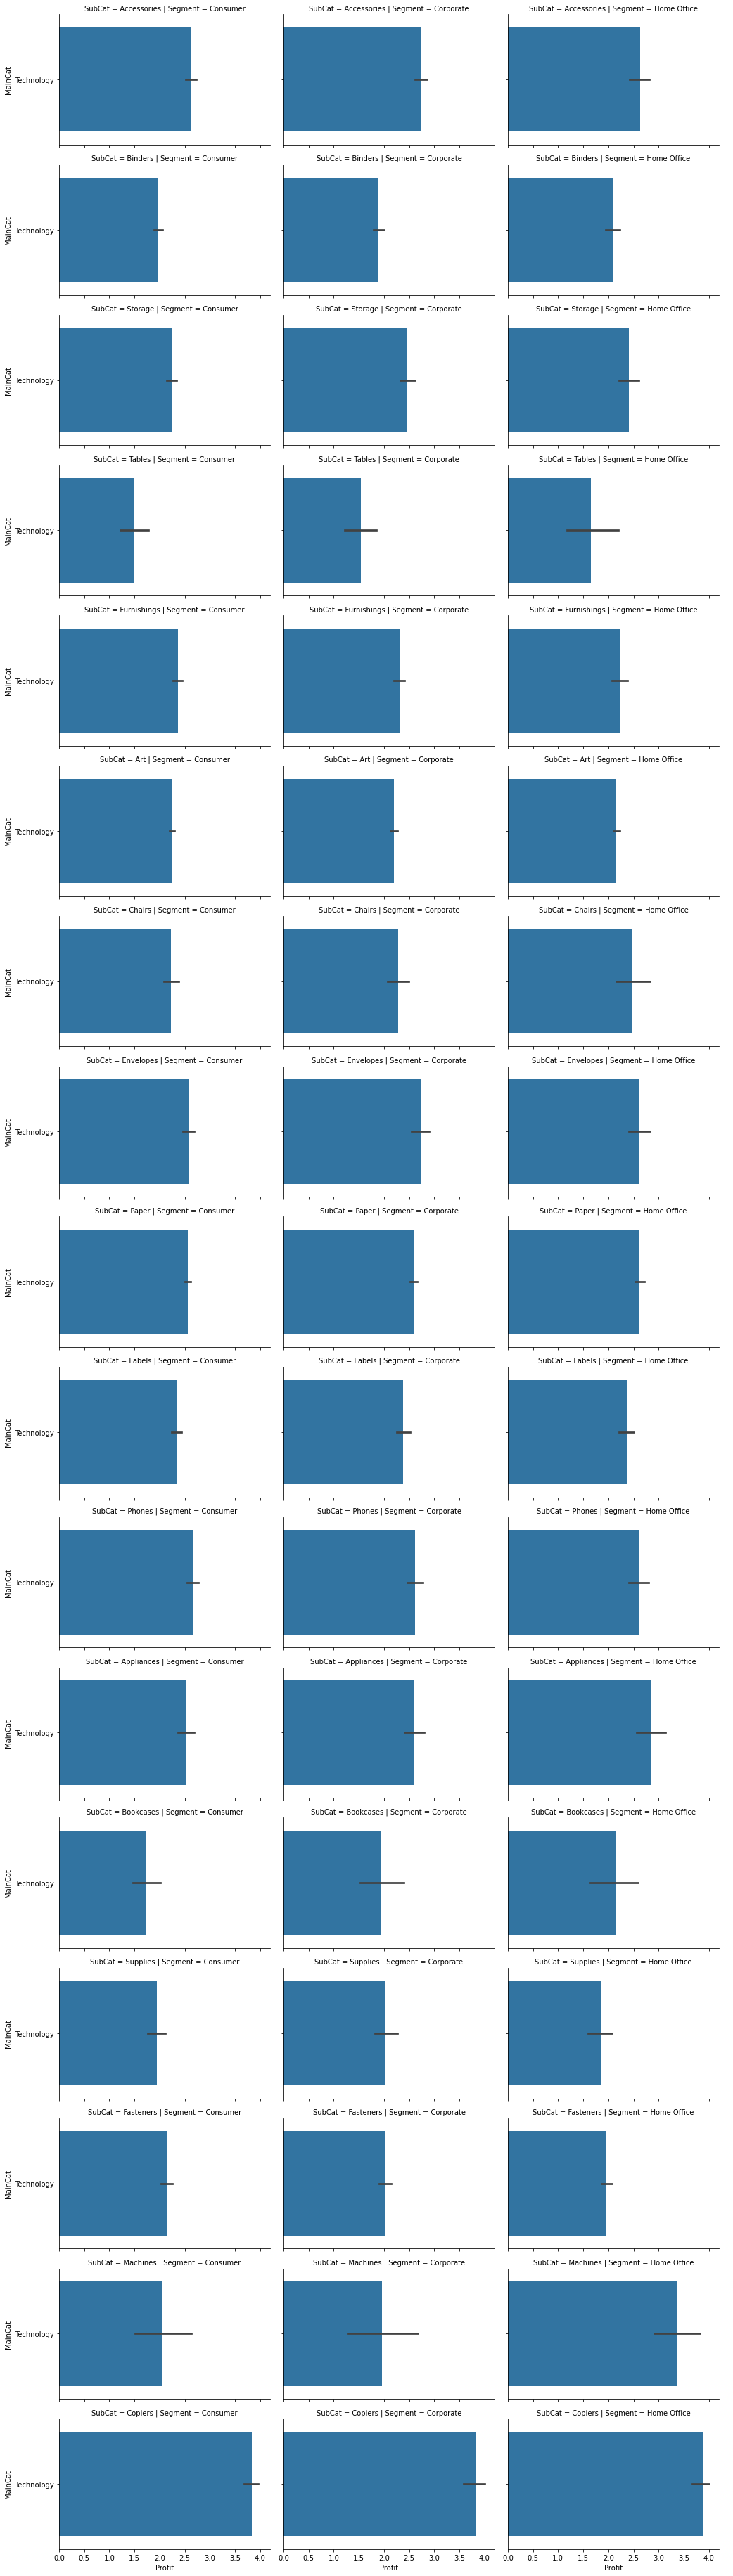

In [39]:
grid = sns.FacetGrid(df, row='SubCat', col='Segment', aspect=1.6)
grid.map(sns.barplot ,'Profit', 'MainCat').add_legend()

In [40]:
fig=px.sunburst(df,path=['Segment',"MainCat",'SubCat'])
fig.update_traces(textinfo="label+percent parent")
fig.show()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       6396 non-null   object        
 1   Order Date     6396 non-null   datetime64[ns]
 2   Ship Mode      6396 non-null   object        
 3   Customer ID    6396 non-null   object        
 4   Customer Name  6396 non-null   object        
 5   Segment        6396 non-null   object        
 6   City           6396 non-null   object        
 7   State          6396 non-null   object        
 8   Postal Code    6396 non-null   int64         
 9   Region         6396 non-null   object        
 10  Product ID     6396 non-null   object        
 11  Product Name   6396 non-null   object        
 12  Sales          6396 non-null   float64       
 13  Quantity       6396 non-null   int64         
 14  Discount       6396 non-null   float64       
 15  Profit         639

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Accessories'),
  Text(1, 0, 'Binders'),
  Text(2, 0, 'Storage'),
  Text(3, 0, 'Tables'),
  Text(4, 0, 'Furnishings'),
  Text(5, 0, 'Art'),
  Text(6, 0, 'Chairs'),
  Text(7, 0, 'Envelopes'),
  Text(8, 0, 'Paper'),
  Text(9, 0, 'Labels'),
  Text(10, 0, 'Phones'),
  Text(11, 0, 'Appliances'),
  Text(12, 0, 'Bookcases'),
  Text(13, 0, 'Supplies'),
  Text(14, 0, 'Fasteners'),
  Text(15, 0, 'Machines'),
  Text(16, 0, 'Copiers')])

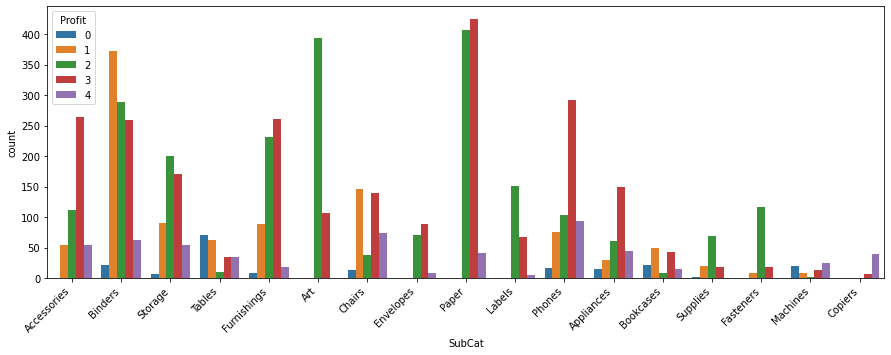

In [42]:
plt.figure(figsize=(15,5))
sns.countplot(x=df['SubCat'],hue=df['Profit'])
plt.xticks(rotation=45, ha='right')


In The Above chart it seems strange that the least percentage of the Segments are home officies while they are the most profitable segments.

In [43]:
fig=px.sunburst(df,path=['Segment',"Discount",'Quantity'])
fig.update_traces(textinfo="label+percent parent")
fig.show()

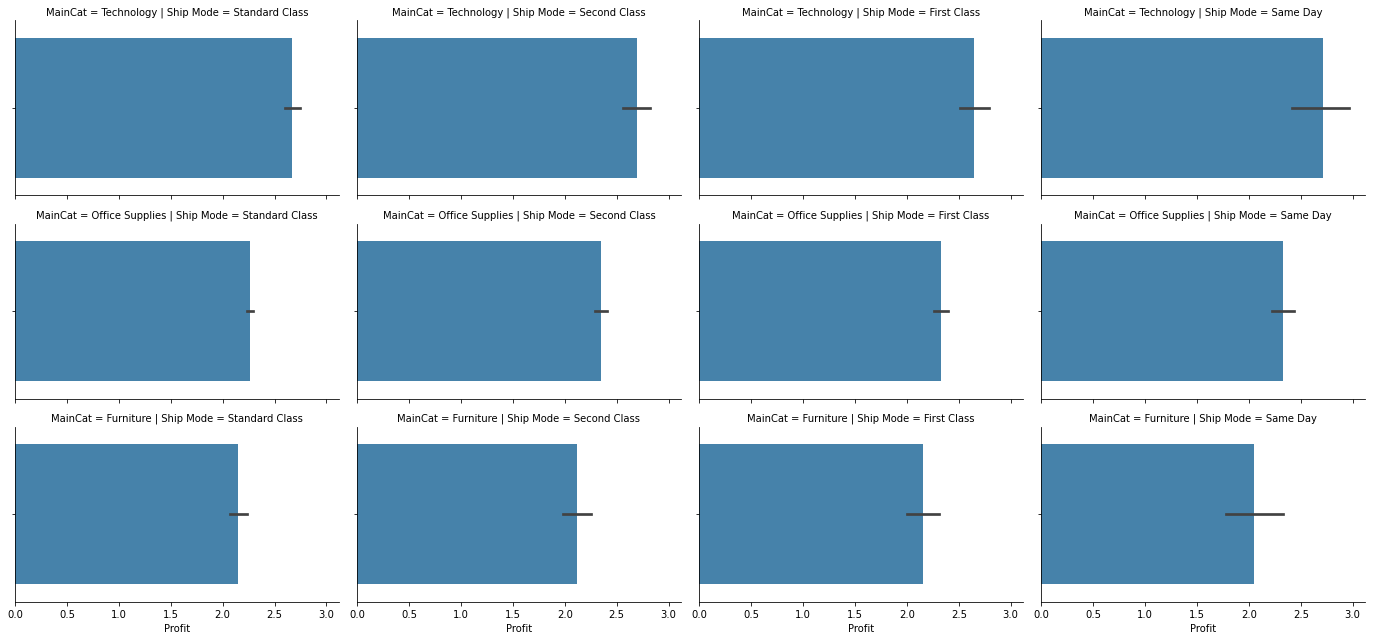

In [44]:
grid = sns.FacetGrid(df, row='MainCat', col='Ship Mode', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

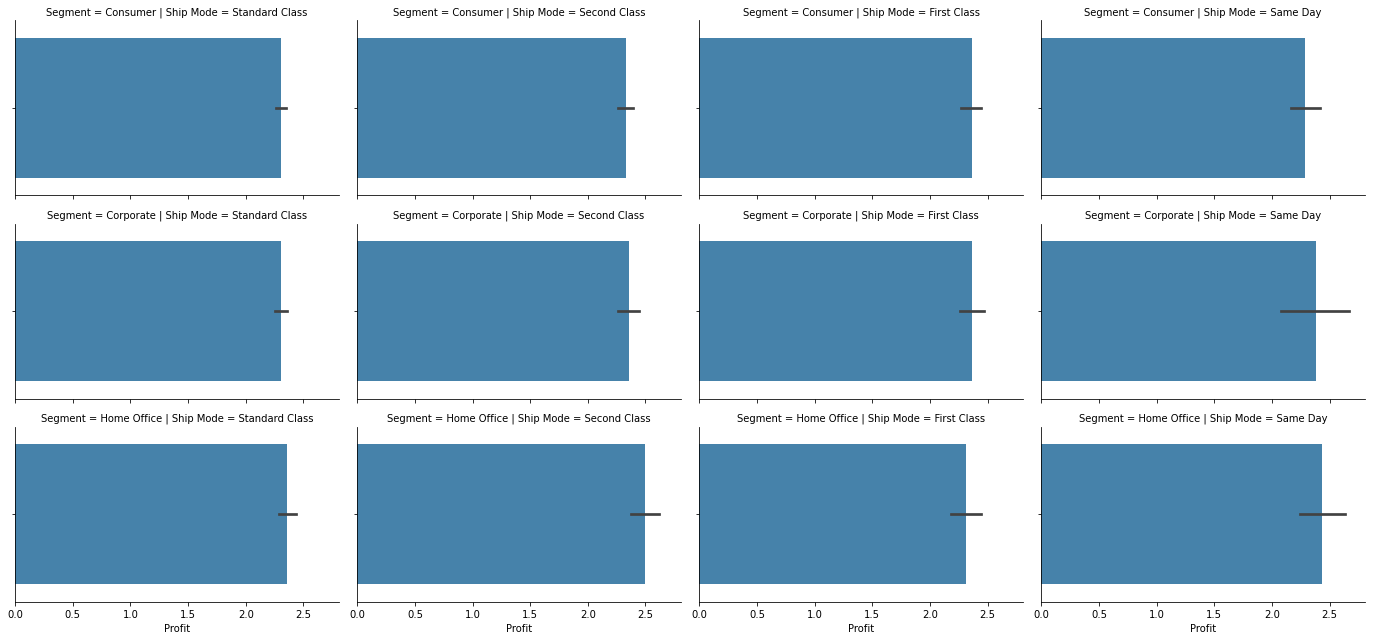

In [45]:
grid = sns.FacetGrid(df, row='Segment', col='Ship Mode', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

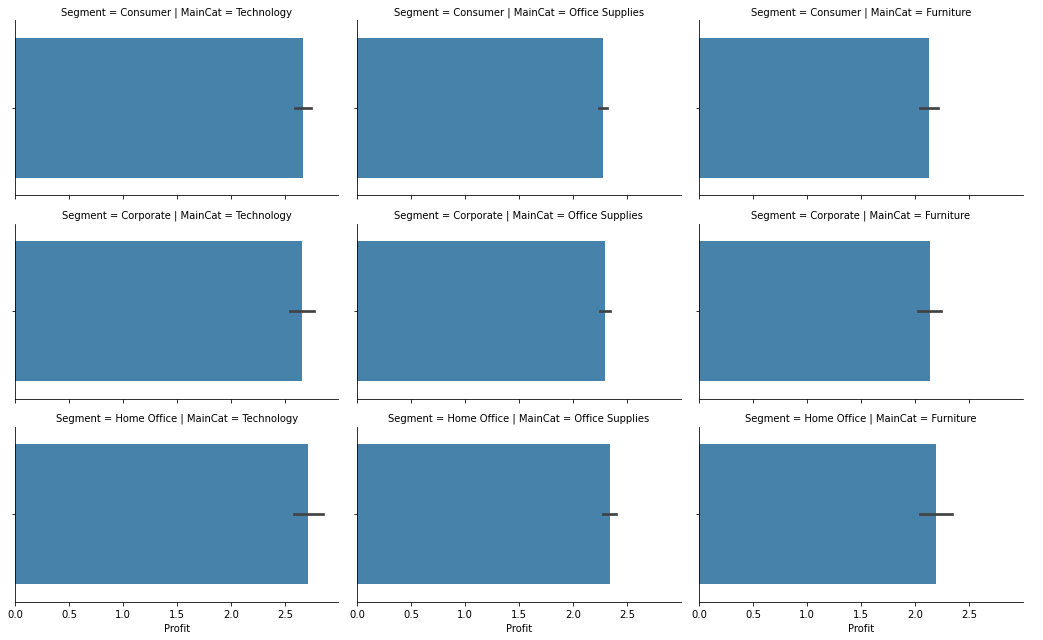

In [46]:
grid = sns.FacetGrid(df, row='Segment', col='MainCat', aspect=1.6)
grid.map(sns.barplot ,'Profit',alpha=.9).add_legend()

Text(0.5, 1.0, 'Max Customer Name buy')

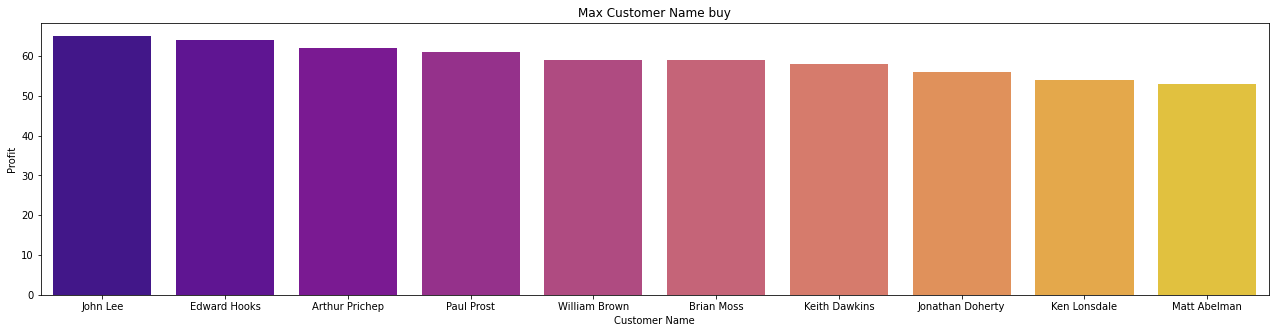

In [47]:
G7=df[['Customer Name','Profit']].groupby(['Customer Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Customer Name', y ='Profit', data = G7[:10],  palette ='plasma')
plt.title('Max Customer Name buy')

Text(0.5, 1.0, 'Most Frequent State Purchase')

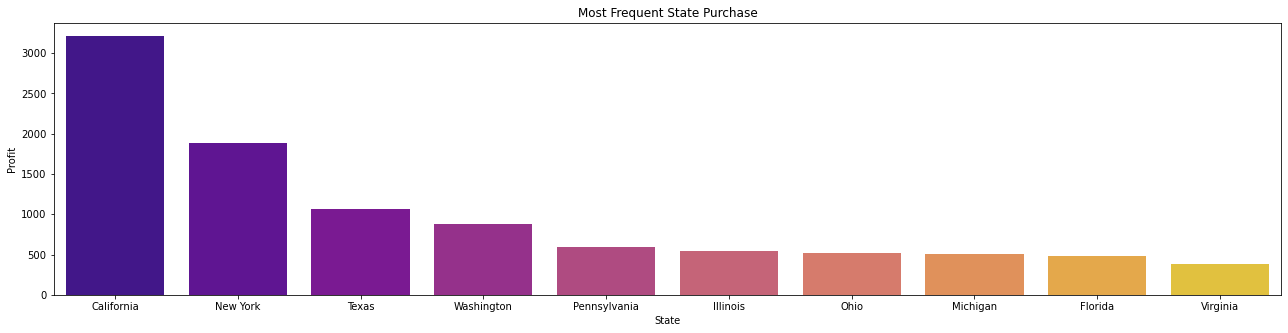

In [48]:
G7=df[['State','Profit']].groupby(['State'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='State', y ='Profit', data = G7[:10],  
            palette ='plasma')
plt.title('Most Frequent State Purchase')

Text(0.5, 1.0, 'Max Customer Name buy')

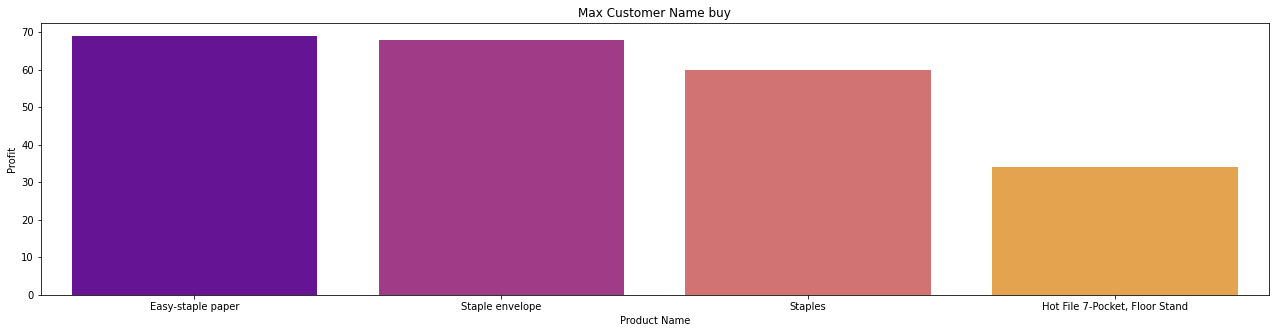

In [49]:
G7=df[['Product Name','Profit']].groupby(['Product Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Product Name', y ='Profit', data = G7[:4],palette ='plasma')
plt.title('Max Customer Name buy')

Text(0.5, 1.0, 'Max Customer Name buy')

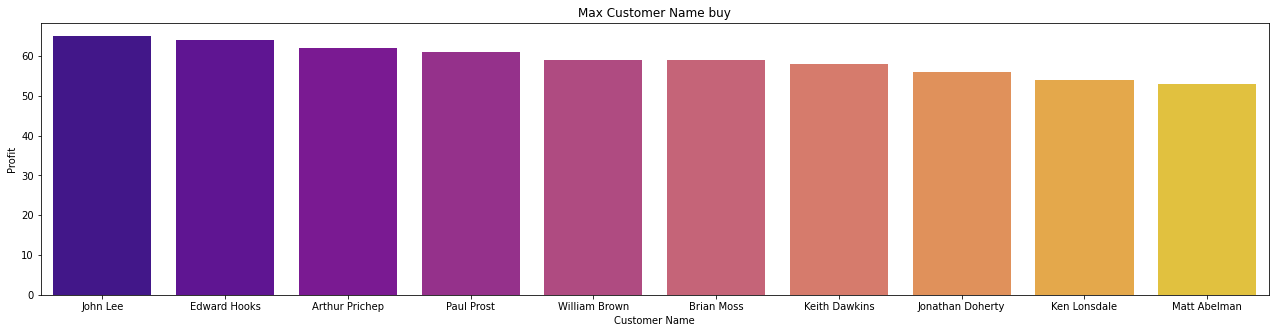

In [50]:
G7=df[['Customer Name','Profit']].groupby(['Customer Name'],as_index=False).sum().sort_values(by='Profit',ascending=False)

plt.figure(figsize=(22, 5))
sns.barplot(x ='Customer Name', y ='Profit', data = G7[:10],  
            palette ='plasma')
plt.title('Max Customer Name buy')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       6396 non-null   object        
 1   Order Date     6396 non-null   datetime64[ns]
 2   Ship Mode      6396 non-null   object        
 3   Customer ID    6396 non-null   object        
 4   Customer Name  6396 non-null   object        
 5   Segment        6396 non-null   object        
 6   City           6396 non-null   object        
 7   State          6396 non-null   object        
 8   Postal Code    6396 non-null   int64         
 9   Region         6396 non-null   object        
 10  Product ID     6396 non-null   object        
 11  Product Name   6396 non-null   object        
 12  Sales          6396 non-null   float64       
 13  Quantity       6396 non-null   int64         
 14  Discount       6396 non-null   float64       
 15  Profit         639

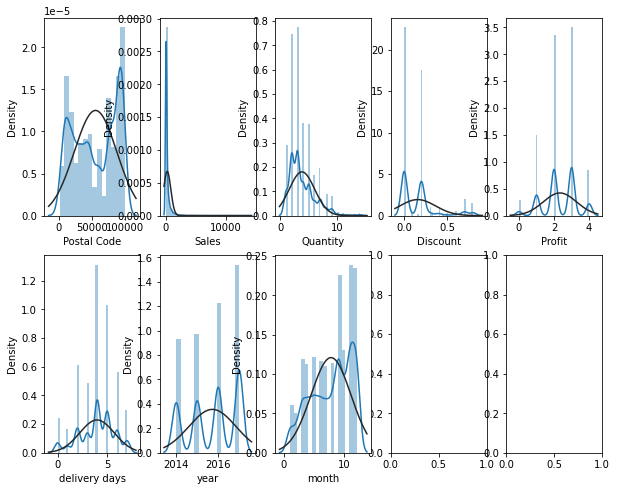

In [52]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for z,i in enumerate( df.select_dtypes(exclude=['object','datetime']).columns):
  plt.subplot(2,w,z+1)
  sns.distplot(df[i], fit=norm);
        

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       6396 non-null   object        
 1   Order Date     6396 non-null   datetime64[ns]
 2   Ship Mode      6396 non-null   object        
 3   Customer ID    6396 non-null   object        
 4   Customer Name  6396 non-null   object        
 5   Segment        6396 non-null   object        
 6   City           6396 non-null   object        
 7   State          6396 non-null   object        
 8   Postal Code    6396 non-null   int64         
 9   Region         6396 non-null   object        
 10  Product ID     6396 non-null   object        
 11  Product Name   6396 non-null   object        
 12  Sales          6396 non-null   float64       
 13  Quantity       6396 non-null   int64         
 14  Discount       6396 non-null   float64       
 15  Profit         639

In [54]:
df['Quantity']=np.log2(df['Quantity']+1)
df['Discount']=np.log2(df['Discount']+1)
df['Sales']=np.log10(df['Sales'])

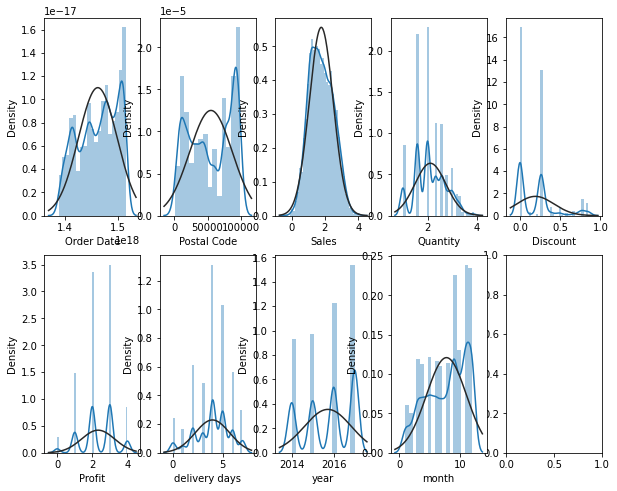

In [55]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for i in df.columns:
    if(df[i].dtypes!='object'):
        plt.subplot(2,w,z)
        sns.distplot(df[i], fit=norm);
        z=z+1

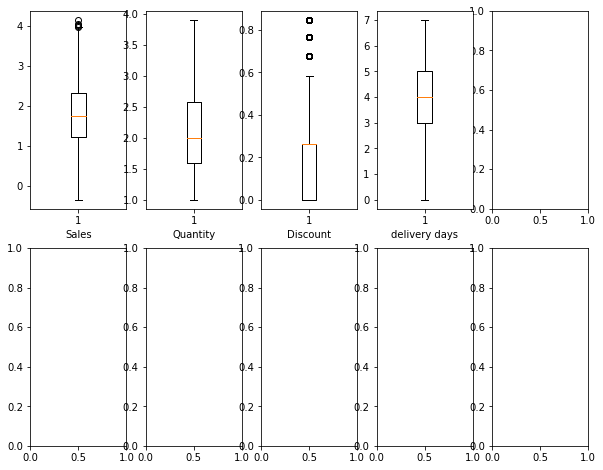

In [56]:
w=int(len(df.select_dtypes(exclude=['datetime','object']).columns)/2)+1

fig, ax = plt.subplots(2,w,figsize=(10,8))
z=1
for i in df.select_dtypes(include=['float','int']).columns:
  plt.subplot(2,w,z)
  plt.boxplot(df[i]);
  plt.xlabel(i)
  z=z+1

In [57]:
idx=list()
def outliers_detection(df):
  for col in df.select_dtypes(include=['int', 'float']).columns:
    Q1=np.quantile(df[col],0.05)
    Q3=np.quantile(df[col],0.95)
    IQR=Q3-Q1
    upperwhisker=Q3+1.5*IQR
    lowerwhisker=Q1-1.5*IQR
    print("Column "+col)
    print(len(df[(df[col]>upperwhisker) + (df[col]<lowerwhisker)]))
    for ind in df[(df[col]>upperwhisker) + (df[col]<lowerwhisker)].index:
      idx.append(ind)
  return idx

idxs=outliers_detection(df)

Column Sales
0
Column Quantity
0
Column Discount
0
Column delivery days
0


In [58]:
df.drop(idxs,axis=0)

,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,...,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat,delivery days,year,month
6800,CA-2014-138072,2014-12-30,Standard Class,GA-14725,Guy Armstrong,Consumer,Philadelphia,Pennsylvania,19120,East,...,"Maxell Pro 80 Minute CD-R, 10/Pack",1.446661,1.584963,0.263034,2,Technology,Accessories,4.0,2014,12
6590,CA-2017-112515,2017-09-17,Second Class,AS-10225,Alan Schoenberger,Corporate,Provo,Utah,84604,West,...,"GBC Pre-Punched Binding Paper, Plastic, White,...",1.407968,1.584963,0.263034,2,Office Supplies,Binders,4.0,2017,9
1277,CA-2016-125087,2016-04-18,Standard Class,TH-21115,Thea Hudgings,Corporate,Houston,Texas,77070,Central,...,Tennsco 16-Compartment Lockers with Coat Rack,3.191713,2.000000,0.263034,3,Office Supplies,Storage,5.0,2016,4
2012,CA-2016-151498,2016-04-21,First Class,DN-13690,Duane Noonan,Consumer,Seattle,Washington,98115,West,...,Round Ring Binders,0.920123,2.584963,0.263034,2,Office Supplies,Binders,3.0,2016,4
2234,CA-2016-169838,2016-11-25,Standard Class,BB-11545,Brenda Bowman,Corporate,Jackson,Michigan,49201,Central,...,Chromcraft Round Conference Tables,3.195515,3.321928,0.000000,4,Furniture,Tables,4.0,2016,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,US-2014-105767,2014-05-23,Standard Class,AR-10510,Andrew Roberts,Consumer,Philadelphia,Pennsylvania,19134,East,...,Motorola L804,1.741845,1.584963,0.485427,1,Technology,Phones,4.0,2014,5
5449,CA-2017-131254,2017-11-19,First Class,NC-18415,Nathan Cano,Consumer,Houston,Texas,77095,Central,...,Avery Hi-Liter GlideStik Fluorescent Highlight...,1.115278,2.584963,0.263034,2,Office Supplies,Art,2.0,2017,11
904,CA-2015-156118,2015-12-08,Standard Class,HG-14965,Henry Goldwyn,Corporate,Colorado Springs,Colorado,80906,West,...,Southworth Parchment Paper & Envelopes,1.195789,2.000000,0.263034,2,Office Supplies,Paper,4.0,2015,12
4498,CA-2017-155740,2017-07-30,First Class,TC-21475,Tony Chapman,Home Office,Lakewood,Ohio,44107,East,...,GBC ProClick Punch Binding System,1.885225,2.321928,0.765535,1,Office Supplies,Binders,3.0,2017,7


In [59]:
df=df.drop(idxs,axis=0)

In [60]:
df

,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,...,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat,delivery days,year,month
6800,CA-2014-138072,2014-12-30,Standard Class,GA-14725,Guy Armstrong,Consumer,Philadelphia,Pennsylvania,19120,East,...,"Maxell Pro 80 Minute CD-R, 10/Pack",1.446661,1.584963,0.263034,2,Technology,Accessories,4.0,2014,12
6590,CA-2017-112515,2017-09-17,Second Class,AS-10225,Alan Schoenberger,Corporate,Provo,Utah,84604,West,...,"GBC Pre-Punched Binding Paper, Plastic, White,...",1.407968,1.584963,0.263034,2,Office Supplies,Binders,4.0,2017,9
1277,CA-2016-125087,2016-04-18,Standard Class,TH-21115,Thea Hudgings,Corporate,Houston,Texas,77070,Central,...,Tennsco 16-Compartment Lockers with Coat Rack,3.191713,2.000000,0.263034,3,Office Supplies,Storage,5.0,2016,4
2012,CA-2016-151498,2016-04-21,First Class,DN-13690,Duane Noonan,Consumer,Seattle,Washington,98115,West,...,Round Ring Binders,0.920123,2.584963,0.263034,2,Office Supplies,Binders,3.0,2016,4
2234,CA-2016-169838,2016-11-25,Standard Class,BB-11545,Brenda Bowman,Corporate,Jackson,Michigan,49201,Central,...,Chromcraft Round Conference Tables,3.195515,3.321928,0.000000,4,Furniture,Tables,4.0,2016,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,US-2014-105767,2014-05-23,Standard Class,AR-10510,Andrew Roberts,Consumer,Philadelphia,Pennsylvania,19134,East,...,Motorola L804,1.741845,1.584963,0.485427,1,Technology,Phones,4.0,2014,5
5449,CA-2017-131254,2017-11-19,First Class,NC-18415,Nathan Cano,Consumer,Houston,Texas,77095,Central,...,Avery Hi-Liter GlideStik Fluorescent Highlight...,1.115278,2.584963,0.263034,2,Office Supplies,Art,2.0,2017,11
904,CA-2015-156118,2015-12-08,Standard Class,HG-14965,Henry Goldwyn,Corporate,Colorado Springs,Colorado,80906,West,...,Southworth Parchment Paper & Envelopes,1.195789,2.000000,0.263034,2,Office Supplies,Paper,4.0,2015,12
4498,CA-2017-155740,2017-07-30,First Class,TC-21475,Tony Chapman,Home Office,Lakewood,Ohio,44107,East,...,GBC ProClick Punch Binding System,1.885225,2.321928,0.765535,1,Office Supplies,Binders,3.0,2017,7


# Dealing With Categorical Features

In [61]:
df['Product ID']=df['Product ID'].str.split('-',expand=True)[2].astype('int64')
df['Customer ID']=df['Customer ID'].str.split('-',expand=True)[1].astype('int64')
df['Order IDs']=df['Order ID'].str.split('-',expand=True)[2].astype('int64')    
df.drop(['Order ID',"Order Date"],axis=1,inplace=True)

In This Part We tried to extract features 

1.   We extracted the numerical value in Prodict ID despite it has a pattern
2.   We extracted the numerical value in Customer ID despite it has a pattern
3.   We extracted the numerical value in Order ID despite it has a pattern



In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 6800 to 5713
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ship Mode      6396 non-null   object 
 1   Customer ID    6396 non-null   int64  
 2   Customer Name  6396 non-null   object 
 3   Segment        6396 non-null   object 
 4   City           6396 non-null   object 
 5   State          6396 non-null   object 
 6   Postal Code    6396 non-null   int64  
 7   Region         6396 non-null   object 
 8   Product ID     6396 non-null   int64  
 9   Product Name   6396 non-null   object 
 10  Sales          6396 non-null   float64
 11  Quantity       6396 non-null   float64
 12  Discount       6396 non-null   float64
 13  Profit         6396 non-null   int64  
 14  MainCat        6396 non-null   object 
 15  SubCat         6396 non-null   object 
 16  delivery days  6396 non-null   float64
 17  year           6396 non-null   int64  
 18  month

In [63]:
scale=MinMaxScaler(feature_range=(-1,1))
scale.fit(df.select_dtypes(exclude=["datetime","object"]).drop("Profit",axis=1))
scaled_cols=df.select_dtypes(exclude=["datetime","object"]).drop("Profit",axis=1).columns
df[scaled_cols]=scale.transform(df[scaled_cols])

In [64]:
import pickle
pickle_out = open("Saved Object (clf)/Myscale.pickle","wb")
pickle.dump(scale, pickle_out)
pickle_out.close()

Here We Scaled The features Between -1 and 1

In [65]:
df=States_Encoding(df,r"Saved Object\UStatesDict.pkl")

In [66]:
df

,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,Region,Product ID,Product Name,Sales,Quantity,Discount,Profit,MainCat,SubCat,delivery days,year,month,Order IDs,long,lat
6800,Standard Class,-0.209068,Guy Armstrong,Consumer,-0.638889,East,0.943944,"Maxell Pro 80 Minute CD-R, 10/Pack",-0.200097,-0.597534,-0.379634,2,Technology,Accessories,0.142857,-1.000000,1.000000,0.087618,-77.194525,41.203322
6590,Second Class,-0.964736,Alan Schoenberger,Corporate,0.699595,West,0.693293,"GBC Pre-Punched Binding Paper, Plastic, White,...",-0.217299,-0.597534,-0.379634,2,Office Supplies,Binders,0.142857,1.000000,0.454545,-0.642729,-111.093731,39.320980
1277,Standard Class,0.863980,Thea Hudgings,Corporate,0.545601,Central,-0.288889,Tennsco 16-Compartment Lockers with Coat Rack,0.575697,-0.311980,-0.379634,3,Office Supplies,Storage,0.428571,0.333333,-0.454545,-0.283457,-99.901813,31.968599
2012,First Class,-0.382872,Duane Noonan,Consumer,0.975758,West,0.987187,Round Ring Binders,-0.434180,0.090487,-0.379634,2,Office Supplies,Binders,-0.142857,0.333333,-0.454545,0.471294,-120.740139,47.751074
2234,Standard Class,-0.743073,Brenda Bowman,Corporate,-0.024037,Central,-0.563163,Chromcraft Round Conference Tables,0.577388,0.597534,-1.000000,4,Furniture,Tables,0.142857,0.333333,0.818182,0.995399,-85.602364,44.314844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,Standard Class,-0.916877,Andrew Roberts,Consumer,-0.638603,East,0.236436,Motorola L804,-0.068868,-0.597534,0.144879,1,Technology,Phones,0.142857,-1.000000,-0.272727,-0.835567,-77.194525,41.203322
5449,First Class,0.410579,Nathan Cano,Consumer,0.546112,Central,0.550350,Avery Hi-Liter GlideStik Fluorescent Highlight...,-0.347420,0.090487,-0.379634,2,Office Supplies,Art,-0.428571,1.000000,0.818182,-0.107221,-99.901813,31.968599
904,Standard Class,-0.168766,Henry Goldwyn,Corporate,0.624009,West,-0.788188,Southworth Parchment Paper & Envelopes,-0.311627,-0.311980,-0.379634,2,Office Supplies,Paper,0.142857,-0.333333,1.000000,0.603321,-105.782067,39.550051
4498,First Class,0.924433,Tony Chapman,Home Office,-0.128158,East,-0.572773,GBC ProClick Punch Binding System,-0.005126,-0.090487,0.805513,1,Office Supplies,Binders,-0.142857,1.000000,0.090909,0.592519,-82.907123,40.417287


In This Part We used a dictionary that of scrapped data that contains Longitude and Latitude of each state so we can find patterns that is related to order Shipping distance and price and polputation of purchases.

In [67]:
def ordinal_enccoder(df):
    num_feature=[0]
    c_v=[]
    for ghandy,i in enumerate(df.select_dtypes(include='object').columns):

        sentences = df[i].values
        cleaned_sentence = []
        for sentence in sentences:
            word = sentence.lower()  
            word = re.sub(r'^RT[\s]+', '', word)
            word = re.sub(r'#',"",word)
            word = word.split()
            word = [i for i in word if i not in set(stopwords.words('english'))]          
            word = " ".join(word)               ##joining our words back to sentences
            cleaned_sentence.append(word)       ##appending our preprocessed sentence into a new list
            
      
        ## printing our new list
        ## printing our new list
        
        cv = CountVectorizer(max_features = 7)  ##give it a max features as 3
        
        BagofwordSs = cv.fit_transform(cleaned_sentence).toarray()
        
        c_v.append(cv)
        
        num_feature.append(num_feature[-1]+BagofwordSs.shape[1])  
        if (ghandy==0):
          CumBagofwords = BagofwordSs
        else:
          CumBagofwords = np.concatenate([CumBagofwords,BagofwordSs],axis=1)
    
    df.drop(df.select_dtypes(include='object').columns,axis=1,inplace=True)
    result = pd.concat([df.reset_index(), pd.DataFrame(CumBagofwords)], axis=1)
    df=pd.DataFrame(result)   
    return result ,num_feature,c_v


In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
df,num_feature,object_cv=ordinal_enccoder(df)

In [70]:
num_feature

[0, 5, 12, 16, 20, 27, 31, 38]

In [71]:
df.head()

,index,Customer ID,Postal Code,Product ID,Sales,Quantity,Discount,Profit,delivery days,year,...,28,29,30,31,32,33,34,35,36,37
0,6800,-0.209068,-0.638889,0.943944,-0.200097,-0.597534,-0.379634,2,0.142857,-1.000000,...,0,0,1,1,0,0,0,0,0,0
1,6590,-0.964736,0.699595,0.693293,-0.217299,-0.597534,-0.379634,2,0.142857,1.000000,...,1,1,0,0,0,1,0,0,0,0
2,1277,0.863980,0.545601,-0.288889,0.575697,-0.311980,-0.379634,3,0.428571,0.333333,...,1,1,0,0,0,0,0,0,0,1
3,2012,-0.382872,0.975758,0.987187,-0.434180,0.090487,-0.379634,2,-0.142857,0.333333,...,1,1,0,0,0,1,0,0,0,0
4,2234,-0.743073,-0.024037,-0.563163,0.577388,0.597534,-1.000000,4,0.142857,0.333333,...,0,0,0,0,0,0,0,0,0,0


In [72]:
X_train=df.drop('Profit',axis=1)
collls=X_train.columns
X_train=np.array(X_train)
X_train=pd.DataFrame(X_train,columns=map(str,collls) )

y_train=df['Profit']
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train.fillna(0), y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
cols=mutual_info.sort_values(ascending=False)[:30]
cols

Sales          0.596418
Discount       0.359766
Product ID     0.288929
lat            0.172357
Postal Code    0.164942
long           0.141101
Quantity       0.070264
29             0.055280
32             0.051774
35             0.049378
28             0.043877
Customer ID    0.039394
27             0.027900
30             0.027899
33             0.027366
Order IDs      0.025347
21             0.022061
24             0.018948
20             0.015118
month          0.013803
22             0.013514
4              0.013447
26             0.012676
19             0.010235
25             0.009950
1              0.009899
16             0.008256
34             0.008218
23             0.008092
12             0.007231
dtype: float64

In [73]:
cols=np.array(cols.index)
 

In [74]:
X=X_train.loc[:,cols]

In [75]:
X=pd.DataFrame(X,columns=map(str, X.columns) )


In [76]:
columns=list()
for col in X.columns:
    if(col.isnumeric()):
        
        for idx in range(len(num_feature)-1):
              
            if(num_feature[idx] <= int(col) and int(col) <num_feature[idx+1]):
                X=X.drop(col,axis=1)
                for ranga in range(num_feature[idx],num_feature[idx+1]):
                    if(str(ranga) not in columns):
                        columns.append(str(ranga))

In [77]:
X=pd.concat([X,X_train[columns]],axis=1)

In [78]:
cols_list=X.columns

In [79]:
X_train=X
y_train=y_train

In That Part We :


1.   used Count vectorizer to encode text in categorical data so simmilar feature have small eculidian distance
1.   We use F_score in feature selection
1.   We returned the other diminisions of diminsions of features we dropped



In [80]:
X_train=X
y_train=y_train

In [81]:
X_train

,Sales,Discount,Product ID,lat,Postal Code,long,Quantity,Customer ID,Order IDs,month,...,3,4,16,17,18,19,12,13,14,15
0,-0.200097,-0.379634,0.943944,41.203322,-0.638889,-77.194525,-0.597534,-0.209068,0.087618,1.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.217299,-0.379634,0.693293,39.320980,0.699595,-111.093731,-0.597534,-0.964736,-0.642729,0.454545,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.575697,-0.379634,-0.288889,31.968599,0.545601,-99.901813,-0.311980,0.863980,-0.283457,-0.454545,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.434180,-0.379634,0.987187,47.751074,0.975758,-120.740139,0.090487,-0.382872,0.471294,-0.454545,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.577388,-1.000000,-0.563163,44.314844,-0.024037,-85.602364,0.597534,-0.743073,0.995399,0.818182,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391,-0.068868,0.144879,0.236436,41.203322,-0.638603,-77.194525,-0.597534,-0.916877,-0.835567,-0.272727,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6392,-0.347420,-0.379634,0.550350,31.968599,0.546112,-99.901813,0.090487,0.410579,-0.107221,0.818182,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6393,-0.311627,-0.379634,-0.788188,39.550051,0.624009,-105.782067,-0.311980,-0.168766,0.603321,1.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6394,-0.005126,0.805513,-0.572773,40.417287,-0.128158,-82.907123,-0.090487,0.924433,0.592519,0.090909,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [82]:
cols_list

Index(['Sales', 'Discount', 'Product ID', 'lat', 'Postal Code', 'long',
       'Quantity', 'Customer ID', 'Order IDs', 'month', '27', '28', '29', '30',
       '31', '32', '33', '34', '35', '36', '37', '20', '21', '22', '23', '24',
       '25', '26', '0', '1', '2', '3', '4', '16', '17', '18', '19', '12', '13',
       '14', '15'],
      dtype='object')

In [83]:
X_test,y_test=preprocessed(df_test,object_cv,scale,cols_list,True)

In [84]:
X_test,y_test

(         Sales  Discount  Product ID        lat  Postal Code        long  \
 0    -0.220833 -0.379634   -0.741742  40.417287    -0.128199  -82.907123   
 1     0.388403 -0.675698    0.318919  43.299428    -0.824810  -74.217933   
 2     0.495119 -1.000000    0.141542  37.964253     0.315387  -91.831833   
 3     0.772337 -0.379634   -0.457457  43.299428    -0.824585  -74.217933   
 4     0.094840 -1.000000   -0.390190  41.580095    -0.970260  -71.477429   
 ...        ...       ...         ...        ...          ...         ...   
 1594 -0.364241 -0.379634   -0.373373  27.664827    -0.346251  -81.515754   
 1595 -0.412100 -0.379634   -0.811411  43.804133     0.959120 -120.554201   
 1596 -0.342739 -1.000000    0.193994  43.299428    -0.824585  -74.217933   
 1597  0.256429 -1.000000   -0.095896  43.784440     0.057886  -88.787868   
 1598 -0.029130 -1.000000   -0.933934  40.551217    -0.061381  -85.602364   
 
       Quantity  Customer ID  Order IDs     month  ...  3  4  16  17  18  

# Modeling

## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import  LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       195
           1       0.82      0.77      0.80      1004
           2       0.87      0.88      0.87      2265
           3       0.81      0.86      0.83      2357
           4       0.89      0.75      0.81       575

    accuracy                           0.84      6396
   macro avg       0.84      0.79      0.81      6396
weighted avg       0.84      0.84      0.84      6396

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        48
           1       0.82      0.73      0.77       236
           2       0.84      0.89      0.86       560
           3       0.81      0.84      0.82       615
           4       0.84      0.71      0.77       140

    accuracy                           0.82      1599
   macro avg       0.81      0.76      0.78      1599
weighted avg       0.82      0.82      0.82      1599

Best Score is : 83.76


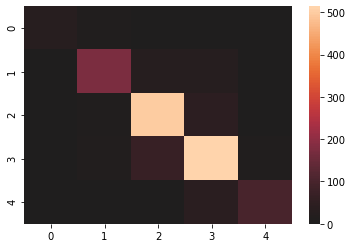

In [86]:
X_train=X_train
Y_train=y_train
X_Test=X_test
VD=y_test
logreg = LogisticRegression(random_state=False,penalty='l2', solver= 'newton-cg')
logreg.fit(X_train, Y_train)
Y_pred_train = logreg.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = logreg.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log
print('Best Score is :',acc_log)
VdD_predict=logreg.predict(X_Test)
cm = confusion_matrix(VD, VdD_predict)
print('confusion matrix = \n',cm)
sns.heatmap(cm, center = True)
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.46      0.59       195
           1       0.81      0.75      0.78      1004
           2       0.85      0.88      0.87      2265
           3       0.76      0.86      0.80      2357
           4       0.89      0.50      0.64       575

    accuracy                           0.81      6396
   macro avg       0.83      0.69      0.74      6396
weighted avg       0.81      0.81      0.80      6396

              precision    recall  f1-score   support

           0       0.75      0.31      0.44        48
           1       0.78      0.72      0.74       236
           2       0.82      0.88      0.85       560
           3       0.76      0.83      0.80       615
           4       0.87      0.53      0.66       140

    accuracy                           0.79      1599
   macro avg       0.80      0.65      0.70      1599
weighted avg       0.79      0.79      0.78      1599

Best Score is : 80.53


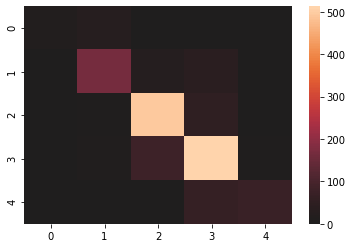

In [87]:
X_train=X_train
Y_train=y_train
X_Test=X_test
VD=y_test
logreg = LogisticRegression(random_state=False,penalty='l2',solver= 'newton-cg',C=0.1)
logreg.fit(X_train, Y_train)
Y_pred_train = logreg.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = logreg.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log
print('Best Score is :',acc_log)
VdD_predict=logreg.predict(X_Test)
cm = confusion_matrix(VD, VdD_predict)
print('confusion matrix = \n',cm)
sns.heatmap(cm, center = True)
plt.show()

## Poly Logestic Regression

In [88]:
from sklearn.preprocessing import PolynomialFeatures
ptrans=PolynomialFeatures(degree=3)
X_train_poly=ptrans.fit_transform(X_train[cols_list[0:22]])
X_test_poly=ptrans.transform(X_test[cols_list[0:22]])

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       195
           1       0.84      0.82      0.83      1004
           2       0.90      0.88      0.89      2265
           3       0.84      0.88      0.86      2357
           4       0.89      0.85      0.87       575

    accuracy                           0.87      6396
   macro avg       0.87      0.85      0.86      6396
weighted avg       0.87      0.87      0.87      6396

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        48
           1       0.82      0.76      0.79       236
           2       0.85      0.86      0.86       560
           3       0.82      0.84      0.83       615
           4       0.82      0.76      0.79       140

    accuracy                           0.83      1599
   macro avg       0.83      0.82      0.82      1599
weighted avg       0.83      0.83      0.83      1599

Best Score is : 86.59


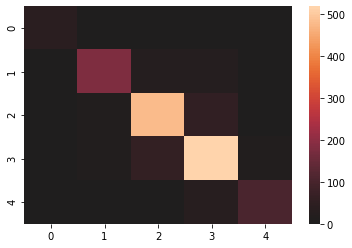

In [89]:
logreg = LogisticRegression(penalty='l2',solver= 'newton-cg',C=0.1,n_jobs=4,random_state=45)
logreg.fit(X_train_poly, Y_train)
Y_pred_train = logreg.predict(X_train_poly)

print(classification_report(Y_train,Y_pred_train))
Y_pred = logreg.predict(X_test_poly)
print(classification_report(y_test,Y_pred))

acc_log = round(logreg.score(X_train_poly, Y_train) * 100, 2)
acc_log
print('Best Score is :',acc_log)
VdD_predict=logreg.predict(X_test_poly)
cm = confusion_matrix(VD, VdD_predict)
print('confusion matrix = \n',cm)
sns.heatmap(cm, center = True)
plt.show()

<h2>Decision Tree Classifiction</h2>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00      2265
           3       1.00      1.00      1.00      2357
           4       1.00      1.00      1.00       575

    accuracy                           1.00      6396
   macro avg       1.00      1.00      1.00      6396
weighted avg       1.00      1.00      1.00      6396

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        48
           1       0.76      0.78      0.77       236
           2       0.86      0.86      0.86       560
           3       0.84      0.84      0.84       615
           4       0.76      0.79      0.77       140

    accuracy                           0.83      1599
   macro avg       0.79      0.78      0.79      1599
weighted avg       0.83      0.83      0.83      1599

Best Score is : 100.0


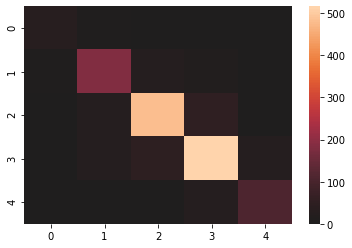

In [95]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=False)
decision_tree.fit(X_train, Y_train)
Y_pred_train = decision_tree.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = decision_tree.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree
print('Best Score is :',acc_decision_tree)
VD_predict=decision_tree.predict(X_Test)
cm = confusion_matrix(VD, VD_predict)
print('confusion matrix = \n',cm)
sns.heatmap(cm, center = True)
plt.show()

## Random Forest Classification


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00      2265
           3       1.00      1.00      1.00      2357
           4       1.00      1.00      1.00       575

    accuracy                           1.00      6396
   macro avg       1.00      1.00      1.00      6396
weighted avg       1.00      1.00      1.00      6396

              precision    recall  f1-score   support

           0       0.76      0.46      0.57        48
           1       0.80      0.73      0.76       236
           2       0.90      0.85      0.87       560
           3       0.78      0.91      0.84       615
           4       0.87      0.66      0.75       140

    accuracy                           0.83      1599
   macro avg       0.82      0.72      0.76      1599
weighted avg       0.83      0.83      0.82      1599

Best Score is : 100.0


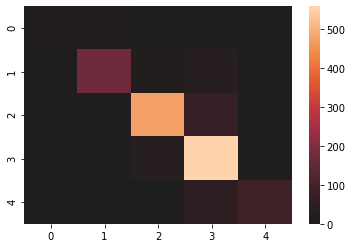

In [96]:
random_forest = RandomForestClassifier(random_state=2002,n_estimators=200)
random_forest.fit(X_train, Y_train)
Y_pred_train = random_forest.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = random_forest.predict(X_test)
print(classification_report(y_test,Y_pred))
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest
print('Best Score is :',acc_random_forest)
VD_predict=random_forest.predict(X_Test)
cm = confusion_matrix(VD, VD_predict)
print('confusion matrix = \n',cm)
sns.heatmap(cm, center = True)
plt.show()

## XGBRegressor

In [93]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')
XGmodel = XGBClassifier(eval_metric=f1,booster='gbtree')
XGmodel.fit(X_train, y_train)
print(XGmodel.score(X_train,y_train))
print(XGmodel.score(X_test,y_test))
Y_pred_train=XGmodel.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = XGmodel.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_linear_svc = round(XGmodel.score(X_train, Y_train) * 100, 2)
acc_linear_svc
print('Best Score is :',acc_linear_svc)
VD_predict=XGmodel.predict(X_Test)
cm = confusion_matrix(VD, VD_predict)
print('confusion matrix = \n',cm)

[14:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9996873045653534
0.8561601000625391
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00      2265
           3       1.00      1.00      1.00      2357
           4       1.00      1.00      1.00       575

    accuracy                           1.00      6396
   macro avg       1.00      1.00      1.00      6396
weighted avg       1.00      1.00      1.00      6396

              precision    recall  f1-score   support

           0       0.78      0.65      0.70        48
           1       0.82      0.78      0.80       236

In [112]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
XGmodel = XGBClassifier(eval_metric=f1_score,booster='gbtree', n_estimators=90)
XGmodel.fit(X_train, y_train)
print(XGmodel.score(X_train,y_train))
print(XGmodel.score(X_test,y_test))
Y_pred_train=XGmodel.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
Y_pred = XGmodel.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_linear_svc = round(XGmodel.score(X_train, Y_train) * 100, 2)
acc_linear_svc
print('Best Score is :',acc_linear_svc)
VD_predict=XGmodel.predict(X_Test)
cm = confusion_matrix(VD, VD_predict)
print('confusion matrix = \n',cm)

[15:05:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9984365228267668
0.8561601000625391
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00      2265
           3       1.00      1.00      1.00      2357
           4       1.00      1.00      1.00       575

    accuracy                           1.00      6396
   macro avg       1.00      1.00      1.00      6396
weighted avg       1.00      1.00      1.00      6396

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        48
           1       0.82      0.76      0.79       236

<h2>SVM (Kernals)<h/2>

In [101]:
from sklearn.svm import SVC

models=SVC(gamma='auto')
models.fit(X_train,y_train)
print(models.score(X_train,y_train))
print(models.score(X_test,y_test))
Y_pred_train=models.predict(X_train)
print(classification_report(Y_train,Y_pred_train))
Y_pred = models.predict(X_test)
print(classification_report(y_test,Y_pred))

acc_linear_svc = round(models.score(X_train, Y_train) * 100, 2)
acc_linear_svc
print('Best Score is :',acc_linear_svc)
VD_predict=models.predict(X_Test)
cm = confusion_matrix(VD, VD_predict)
print('confusion matrix = \n',cm)


print("------------RBF------------")
models=SVC(kernel='rbf',C=3000,gamma=2)
models.fit(X_train,y_train)
print(models.score(X_train,y_train))
print(models.score(X_test,y_test))
Y_pred_train=models.predict(X_train)
print(classification_report(Y_train,Y_pred_train))
y_pred = models.predict(X_test)
print(classification_report(y_test,y_pred))

acc_linear_svc = round(models.score(X_train, y_train) * 100, 2)

print('Best Score is :',acc_linear_svc)

VD_predict=models.predict(X_Test)

cm = confusion_matrix(VD, VD_predict)

print('confusion matrix = \n',cm)


print("------------poly------------")
models=SVC(kernel='poly')
models.fit(X_train,y_train)
print(models.score(X_train,y_train))
print(models.score(X_test,y_test))
Y_pred_train=models.predict(X_train)
print(classification_report(Y_train,Y_pred_train))
y_pred = models.predict(X_test)
print(classification_report(y_test,y_pred))

acc_linear_svc = round(models.score(X_train, y_train) * 100, 2)

print('Best Score is :',acc_linear_svc)

VD_predict=models.predict(X_Test)

cm = confusion_matrix(VD, VD_predict)

print('confusion matrix = \n',cm)

print("------------Sigmoid------------")
models=SVC(kernel='sigmoid')
models.fit(X_train,y_train)
print(models.score(X_train,y_train))
print(models.score(X_test,y_test))
Y_pred_train=models.predict(X_train)

print(classification_report(Y_train,Y_pred_train))
y_pred = models.predict(X_test)
print(classification_report(y_test,y_pred))

acc_linear_svc = round(models.score(X_train, y_train) * 100, 2)

print('Best Score is :',acc_linear_svc)

VD_predict=models.predict(X_Test)

cm = confusion_matrix(VD, VD_predict)

print('confusion matrix = \n',cm)


0.7182614133833646
0.6941838649155723
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       195
           1       0.81      0.69      0.75      1004
           2       0.80      0.81      0.80      2265
           3       0.63      0.85      0.73      2357
           4       0.94      0.09      0.16       575

    accuracy                           0.72      6396
   macro avg       0.84      0.50      0.50      6396
weighted avg       0.76      0.72      0.69      6396

              precision    recall  f1-score   support

           0       0.50      0.02      0.04        48
           1       0.78      0.65      0.71       236
           2       0.75      0.79      0.77       560
           3       0.63      0.82      0.71       615
           4       1.00      0.07      0.13       140

    accuracy                           0.69      1599
   macro avg       0.73      0.47      0.47      1599
weighted avg       0.72      0.69      

In [110]:
print("------------RBF------------")
models=SVC(kernel='poly',C=7,gamma=0.01)
models.fit(X_train,y_train)
print(models.score(X_train,y_train))
print(models.score(X_test,y_test))
Y_pred_train=models.predict(X_train)
print(classification_report(Y_train,Y_pred_train))
y_pred = models.predict(X_test)
print(classification_report(y_test,y_pred))

acc_linear_svc = round(models.score(X_train, y_train) * 100, 2)

print('Best Score is :',acc_linear_svc)

VD_predict=models.predict(X_Test)

cm = confusion_matrix(VD, VD_predict)

print('confusion matrix = \n',cm)


------------RBF------------


## Neural Network

In [ ]:
reg = Sequential([ 
# Adding the input layer and the first hidden layer
Dense(units = 512, activation = 'relu'),
# Adding the second hidden layer
Dense(units = 320, activation = 'relu'),
Dense(units = 250, activation = 'relu'),
Dense(units = 128, activation = 'relu'),
Dropout(0.1),
BatchNormalization(),
Dense(units = 64, activation = 'relu'),
# Adding the output layer
Dense(units = 1, activation = 'relu'),

])

In [ ]:
reg.compile(optimizer = 'adam', loss=keras.losses.MeanSquaredError(), metrics = ['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(lr=0.5,monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)
reg.fit(X_train, y_train, batch_size = 5996, epochs = 170,callbacks=[learning_rate_reduction])

In [ ]:
y_pr = reg.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pr)

## GridSearchCV

In [ ]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

clf = GridSearchCV(XGmodel,{'max_depth': [4,6,8],
                    'n_estimators': [100,200],
                    'learning_rate': [0.0001,0.03,0.9],
                    'gamma':[0.9,1.2,3] },
                    n_jobs=6,
                    verbose=1, 
                    scoring=f1)

clf.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[00:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8447715685186413
{'gamma': 0.9, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 200}


In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        48
           1       0.84      0.74      0.79       236
           2       0.90      0.88      0.89       560
           3       0.84      0.89      0.87       615
           4       0.78      0.82      0.80       140

    accuracy                           0.85      1599
   macro avg       0.83      0.80      0.81      1599
weighted avg       0.85      0.85      0.85      1599



# Serialization

In [114]:
'''import pickle
pickle_out = open("Saved Object (clf)/Myscale.pickle","wb")
pickle.dump(scale, pickle_out)
pickle_out.close()
pickle_out = open("Saved Object (clf)/ColsList.pickle","wb")
pickle.dump(cols_list, pickle_out)
pickle_out.close()
pickle_out = open("Saved Object (clf)/CVlist.pickle","wb")
pickle.dump(object_cv, pickle_out)
pickle_out.close()
pickle_out = open("Saved Object (clf)/ptrans.pickle","wb")
pickle.dump(ptrans, pickle_out)
pickle_out.close()
pickle_out = open("Saved Object (clf)/logclf.pickle","wb")
pickle.dump(logreg, pickle_out)
pickle_out.close()
XGmodel.save_model("Saved Object (clf)/XGB.txt")
'''

In [ ]:
'''joblib.dump(scale, 'Saved Object (clf)/Myscale.pkl')
joblib.dump(cols_list,"Saved Object (clf)/ColsList.pkl")
joblib.dump(object_cv,"Saved Object (clf)/CVlist.pkl")'''

['Saved Object (clf)/CVlist.pkl']